In [1]:
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
from glob import glob
import pandas as pd
from copy import deepcopy
import gsw
import gen_utils
from multiprocessing import Pool
import seaborn as sns
sns.set()

to-do
- How to pick thermocline?
    - plot error as a function of iso-line choice
    - figure out which temperature isotherm corresponds to $\theta=12K$
    - extrapolate ADCP to lower level, and find out where it crosses 0. Then choose closest isotherm as boundary...
        - could compare this to choosing mid-thermocline (should give different, better result)
- If have time:
    - satellite data

In [2]:
def velocity_xr(u_vals, v_vals):
    '''Put velocity values in xarray dataarray'''
    # Put on correct grid    
    velocity = xr.DataArray(np.stack([u_vals,v_vals],axis=0), 
                            coords={'name':['u','v'], 'p'   :uv['DepthCenterCell'].values,
                                    'dist':uv['DistanceCenterCell'].values/1000, # convert to km
                                    'time':data.time[::-1]}, dims=['name','time','p','dist'])
    velocity['p'] = -gsw.z_from_p(velocity['p'], lat=40.3) # convert pressure to depth
    velocity      = velocity.rename({'p':'depth'})
    velocity      = velocity.reindex(time=velocity.time[::-1]) # time dimension matches density data
    velocity      = velocity.interp({'dist':data.dist}) # interpolate distances to match density data
    return velocity

def get_ym(data, idx):
    '''Get year and month from the data, given data and index'''
    time = data.time.isel(time=idx)
    y    = time.dt.year.values.item()
    m    = time.dt.month.values.item()
    return y, m

def get_lower_upper(data, iso):
    '''Get quantity averaged over lower and upper layers of the 1.5 layer model'''
    lower_list, upper_list = [], []
    for d in data.dist:
        boundary  = iso.sel(dist=d).values.item() 
        lower = data.sel(dist=d, depth=slice(boundary,None))
        upper = data.sel(dist=d, depth=slice(None,boundary))
        lower, upper = [x.mean('depth').values.item() for x in [lower, upper]]
        lower_list.append(lower)
        upper_list.append(upper)
    return np.array(lower_list), np.array(upper_list)

def get_iso_np(data, x):
    '''Given a dataset and the value of an isopycnal/therm, get coordinates of isopycnal/therm'''
    levels = np.array([x])
    idx = np.where(levels==x)[0].item()
    p = plt.contour(data['dist'], data['depth'], data.T, levels=levels)
    plt.close()
    c = p.allsegs[idx][np.argmax([len(y) for y in p.allsegs[idx]])]
    return c

def get_iso_xr(iso):
    '''Convert isoline to xarray'''
    iso = xr.DataArray(iso[:,1], coords={'dist':pd.Index(iso[:,0])}, dims=['dist'])
    iso = iso.drop_duplicates('dist').interp(dist=data['dist'])
    return iso

def get_iso(data,x):
    '''Combines get_iso_xr and get_iso_np'''
    return get_iso_xr(get_iso_np(data,x))

def get_xgrad(iso):
    '''Compute horizontal gradient of the isoline'''
    return iso.differentiate('dist') / 1000 # convert from km to m

def get_gprime(rho, iso):
    '''Compute reduced gravity, based on isotherm/isopycnal'''
    g = 9.8
    rho_lower, rho_upper = get_lower_upper(rho, iso)
    gprime = deepcopy(iso)
    gprime.values = g * (rho_lower-rho_upper) / (rho_upper + 1000) #
    return gprime

def est_velocity(rho, iso):
    '''Get estimated velocity from data, based on selected iso-line'''
    # Compute coriolis parameter
    omega  = 2*np.pi/(3600*24) # rotation rate of earth (radians/sec)
    f      = 2*omega*np.sin(np.deg2rad(40.3)) # estimate of f0, based on latitude of ~40 degrees N
    
    # Compute horizontal gradient and reduced gravity
    grad   = get_xgrad(iso)
    gprime = get_gprime(rho, iso) # Compute reduced gravity
    v      = gprime / f * grad    # velocity
    return v

def get_mean_zgrad(data, iso, delta):
    '''Get mean vertical gradient given dataarray and iso-line. Delta is the window to avg over.'''
    valid_idx  = np.where(~np.isnan(iso.values))[0] # get non-NaN slices (required for argmin)
    valid_dist = iso.dist.isel(dist=valid_idx)
    iso_       = iso.sel(dist=valid_dist)
    zgrad      = -data.sel(dist=valid_dist).differentiate('depth')
    L = np.abs(zgrad.depth.values - iso_.values[:,None]) # compute distances
    min_idx = np.nanargmin(L, axis=1) 

    # Loop through distances to compute vertical gradient at each location
    zgrads = []
    for d,i in zip(zgrad.dist, min_idx):
        zgrads.append(zgrad.sel(dist=d).isel(depth=slice(i-delta, i+delta)).mean('depth').values.item())
        
    # put results in same data format as isoline
    zgrads_xr = np.nan * deepcopy(iso)
    zgrads_xr.values[valid_idx] = np.array(zgrads)
    
    return zgrads_xr

def get_mean_zgrad_multi(args):
    '''Wrapper function for get_mean_zgrad, which handles multiple iso_vals.
    Returns xarray dataarray.
    Args consist of: data, iso_vals to check, and delta'''
    data, iso_vals, delta = args
    zgrads   = []
    for x in iso_vals:
        iso = get_iso(data, x=x)
        zgrads.append(get_mean_zgrad(data, iso = iso, delta=delta))
    return xr.concat(zgrads, dim=pd.Index(iso_vals, name='isoline')) # Put in nice dataarray

def zip_args(name, iso_vals, delta):
    '''Convenience function: zip arguments (helpful for multiprocessing)'''
    # zip all of arguments into nice list (boiler plate code)
    l1 = [data[name].isel(time=i) for i in range(len(data.time))]
    l2 = [iso_vals for _                in range(len(data.time))]
    l3 = [delta for _                   in range(len(data.time))]
    return zip(l1,l2,l3)

# Load data

## Density

In [3]:
# data  = xr.open_dataset('ctd-data.nc')
data  = xr.open_dataset('ctd-data_no-interp.nc')
data['p'] = -gsw.z_from_p(data['p'], lat=40.3)
data = data.rename({'p':'depth'})

## Velocity
For transformed coordinate system, use projection array computed in ```lab2_load-data.ipynb```

In [4]:
## ADCP velocities
uv = xr.open_dataset('VelocityData.nc')

###### Transformed velocity ######
# Projection matrix
P = np.array([[ 0.44254196, -0.8967478 ],
              [ 0.8967478 ,  0.44254196]])
uv = xr.open_dataset('VelocityData.nc')
u  = uv['AllUArray'].values
v  = uv['AllVArray'].values

# Get transformed velocities
uv_stack = np.stack([u,v],axis=0)
uvhat      = (P @ uv_stack.reshape(2,-1)).reshape(uv_stack.shape)
vhat_adcp = velocity_xr(uvhat[0], uvhat[1])

###### Speed ###########
v_     = np.sqrt(uv['AllUArray']**2 + uv['AllVArray']**2).values
u_     = 0 * deepcopy(v)
speed_adcp = velocity_xr(u_,v_)

# Compute theoretical velocity

Compute geostrophic velocity based on "reduced gravity'' equations:  
$fv = g\nabla \eta_1$  
$\implies v = \frac{g}{f}\frac{\partial\eta_1}{\partial x}$

In [5]:
mpl.rcParams['figure.dpi'] = 200

time_idx      = 1
iso_level     = 12 # 12 degrees C, or 27 kg/m^3 seems to give reasonable results...
name          = 'T' # one of {'T','rho'}
name_plot     = 'T' # which variable to contour on the plots...
plot_velocity = False
take_mean     = False

## take mean if desired
if take_mean:
    data, vhat_adcp, speed_adcp  = [x.mean('time', keepdims=True) for x in [data, vhat_adcp, speed_adcp]]
    
## Compute isoline and velocity
data_ = data.isel(time=time_idx)          # get correct timestep
rho_  = data_['rho']   # density
iso   = get_iso(data_[name], x=iso_level) # compute depth of isoline
vhat  = est_velocity(rho_, iso)           # estimate velocity

# Partition ADCP data by layer
vhat_adcp_lo, vhat_adcp_hi = get_lower_upper(vhat_adcp.sel(name='v').isel(time=time_idx), iso)
s_adcp_lo, s_adcp_hi       = get_lower_upper(speed_adcp.sel(name='v').isel(time=time_idx), iso)

### Integrated transport 
vhat_transport      = vhat          * iso # integrated transport (note: units of iso are 'm')
vhat_adcp_transport = vhat_adcp_hi  * iso
s_adcp_tranport     = s_adcp_hi     * iso

# Plot cross-section and estimated speed
Velocity colors, isothermal/pycnals contoured, with selected isopycnal highlighted

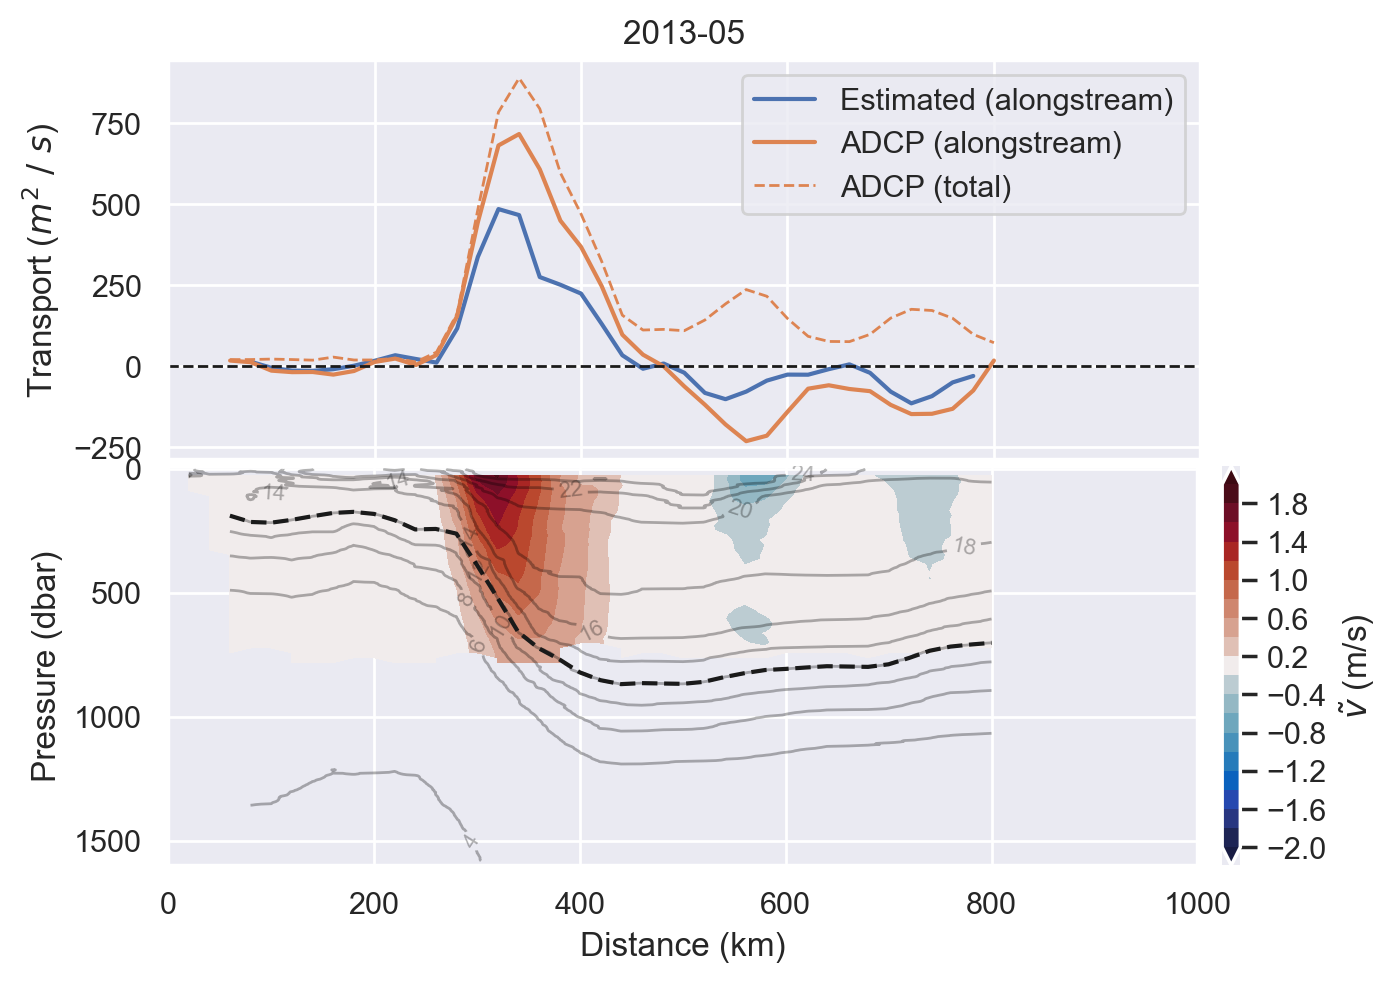

In [42]:
##### Plotting 
c = sns.color_palette()
figsize = np.array([8,16/3])
fig = plt.figure(figsize=figsize)
gs = fig.add_gridspec(20,30)

#### Line plots #####
ax0 = fig.add_subplot(gs[:10,:25])
if plot_velocity:
    p1 = ax0.plot(vhat.dist, vhat.values,  label='Estimated (alongstream)')
    p2 = ax0.plot(vhat.dist, vhat_adcp_hi, color=c[1], label='ADCP (alongstream)')
    p2 = ax0.plot(vhat.dist, s_adcp_hi,    color=c[1], label='ADCP (total)', ls='--', lw=1)
    ax0.set_ylabel('Velocity ($m~/~s$)')
else:
    p1 = ax0.plot(vhat.dist, vhat_transport.values,          label='Estimated (alongstream)')
    p2 = ax0.plot(vhat.dist, vhat_adcp_transport,  color=c[1], label='ADCP (alongstream)')
    p2 = ax0.plot(vhat.dist, s_adcp_tranport,      color=c[1], label='ADCP (total)', ls='--', lw=1)
    ax0.set_ylabel(r'Transport ($m^2~/~s$)')
ax0.set_xticklabels([])
ax0.axhline(0,ls='--',lw=1,c='k')
ax0.set_xlim([0,1000])
ax0.legend()
y,m = get_ym(data, time_idx) if not take_mean else (None,None)
ax0.set_title(f'{y}-{m:02d}' if not take_mean else 'Mean')

#### Plot Velocity profile ####
ax = fig.add_subplot(gs[10:,:])
p = ax.contourf(vhat_adcp.dist, vhat_adcp.depth, vhat_adcp.sel(name='v').isel(time=time_idx), 
                cmap='cmo.balance', levels=gen_utils.make_cb_range(2,.2), extend='both')
cb = fig.colorbar(p, orientation='vertical', label=r'$\tilde{v}$ (m/s)', pad=.02)

# Iso-lines (temperature or density)
data_plot = data.isel(time=time_idx)[name_plot].T
levels    = np.arange(0,25,2) if name_plot=='T' else np.arange(25,28.2,.05)
p = ax.contour(data.dist, data.depth, data_plot, colors='black', linewidths=1,
               levels=levels, extend='both', alpha=.3) # create contour plot
ax.clabel(p, fontsize=8)

ax.plot(iso.dist, iso.values, c='k', ls='--')
ax.set_ylabel('Pressure (dbar)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1600])
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down

plt.show()

# Error as a function of cross section

In [54]:
def get_transport_error(args):
    '''Convenience function to compute transport given dataset, name (one of {'T','rho'}), and iso_level'''
    data, adcp_data, name, iso_level = args
    iso   = get_iso(data[name], x=iso_level) # compute depth of isoline
    vhat  = est_velocity(data['rho'], iso)           # estimate velocity
    # Get adcp velocities averaged over upper/lower levels
    vhat_adcp_lo, vhat_adcp_hi = get_lower_upper(adcp_data, iso)
    ### Integrated transport 
    vhat_transport      = vhat          * iso # integrated transport (note: units of iso are 'm')
    vhat_adcp_transport = vhat_adcp_hi  * iso
#     return vhat_transport - vhat_adcp_transport
    return xr.concat([vhat_transport, vhat_adcp_transport], dim=pd.Index(['est','adcp'],name='transport_type'))

def get_transport_error_multi(args):
    '''Wrapper function which computes transport error for multiple iso-lines'''
    data, adcp_data, name, iso_vals = args
    errors = []
    for x in iso_vals:
        errors.append(get_transport_error((data, adcp_data, name, x)))
    return xr.concat(errors, dim=pd.Index(iso_vals, name='isoline'))

def zip_args_transport(name, iso_vals):
    '''Convenience function: zip arguments (helpful for multiprocessing)'''
    # zip all of arguments into nice list (boiler plate code)
    l1 = [data.isel(time=i)                    for i in range(len(data.time))]
    l2 = [vhat_adcp.sel(name='v').isel(time=i) for i in range(len(data.time))]
    l3 = [name                                 for i in range(len(data.time))]
    l4 = [iso_vals                             for i in range(len(data.time))]
    return zip(l1,l2,l3,l4)

In [64]:
# arguments for experimental setup
name  = 'T'
iso_vals = np.arange(4,23) if name=='T' else np.arange(26,27.75,.1)
arg_list = zip_args_transport(name, iso_vals)

with Pool(16) as p:
    transport_allyears = p.map(get_transport_error_multi, arg_list)
transport_allyears = xr.concat(transport_allyears, dim=data.time)
error_allyears = transport_allyears.sel(transport_type='est') - transport_allyears.sel(transport_type='adcp')

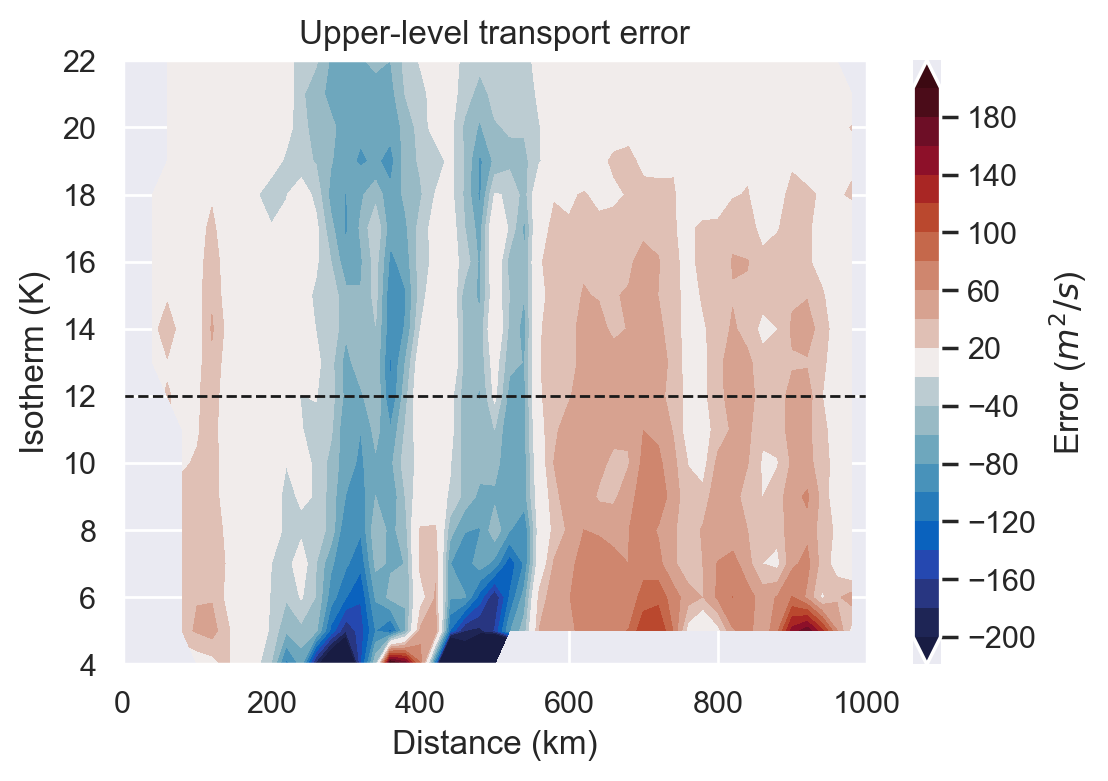

In [124]:
mpl.rcParams['figure.dpi']=200
### Plot as a function of distance
fig,ax = plt.subplots()
cp = ax.contourf(error_allyears.dist, error_allyears.isoline, error_allyears.mean('time',skipna=True), 
                 cmap='cmo.balance', levels=gen_utils.make_cb_range(200,20), extend='both')
cb = fig.colorbar(cp, label=r'Error ($m^2/s$)')
ax.set_ylabel('Isotherm (K)')
ax.set_title(r'Upper-level transport error')
ax.axhline(12, ls='--',c='k',lw=1)
ax.set_xlabel('Distance (km)')
plt.show()

### Plot integrated error

In [99]:
### Integrate error over distance
error_int     = np.abs(error_allyears).fillna(0).integrate('dist')

### Integrate actual transport over distance
transport_int = np.abs(transport_allyears.sel(transport_type='adcp')).fillna(0).integrate('dist')

### Divide error by actual
error_int_scaled = (error_int/transport_int).sel(isoline=slice())
error_int_scaled = error_int_scaled.reindex(isoline=list(reversed(error_int_scaled.isoline)))

In [115]:
mean_g = error_int_scaled.mean('time')
std_g  = error_int_scaled.std('time')

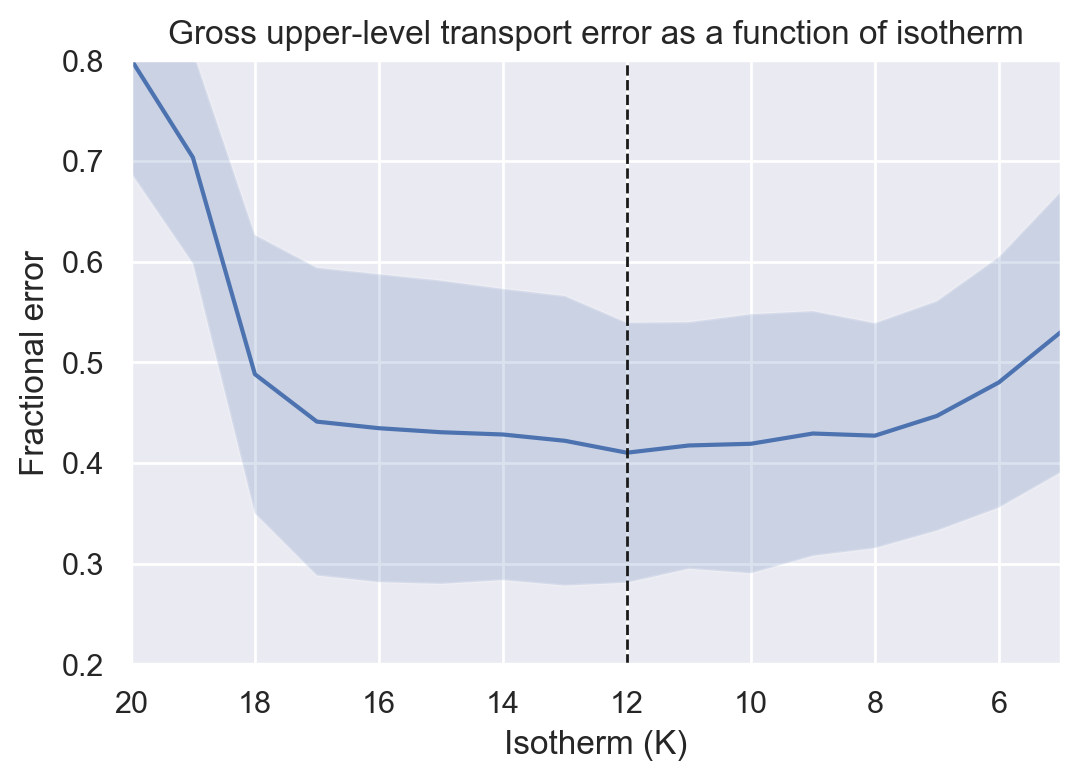

In [123]:
mpl.rcParams['figure.dpi']=200
fig,ax = plt.subplots()
ax.plot(mean_g.isoline, mean_g)
ax.fill_between(mean_g.isoline, mean_g+std_g, mean_g-std_g, alpha=.2)
ax.set_xlim([5,20])
ax.set_ylim([.2,.8])
ax.set_xlim(ax.get_xlim()[::-1])
ax.axvline(12, ls='--',lw=1,c='k')
ax.set_xlabel('Isotherm (K)')
ax.set_ylabel('Fractional error')
ax.set_title('Gross upper-level transport error as a function of isotherm')
plt.show()

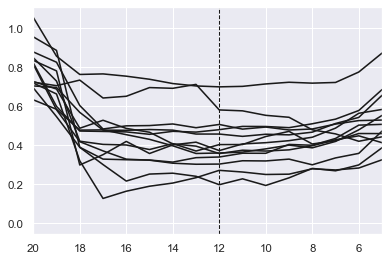

In [108]:
fig,ax = plt.subplots()
for t in error_int_scaled.time:
    ax.plot(error_int_scaled.sel(time=t).isoline, error_int_scaled.sel(time=t).values, color='k')
ax.set_xlim([5,20])
ax.set_xlim(ax.get_xlim()[::-1])
ax.axvline(12, ls='--',lw=1,c='k')
plt.show()

In [86]:
actual_int_mean

<xarray.DataArray (isoline: 19)>
array([0.47966286, 0.53012704, 0.48011081, 0.44679391, 0.42717933,
       0.42931427, 0.41913563, 0.41743808, 0.41026158, 0.42209921,
       0.42834066, 0.43059355, 0.43459957, 0.44112219, 0.48825388,
       0.703612  , 0.80123731, 0.74501429, 0.74293117])
Coordinates:
  * isoline         (isoline) int64 4 5 6 7 8 9 10 11 ... 16 17 18 19 20 21 22
    transport_type  <U4 'adcp'

In [72]:
transport_int = np.abs(transport_allyears).fillna(0).integrate('dist')
transport_int_err = transport_int.sel(transport_type='')

In [45]:
errors_allyears

<xarray.DataArray (time: 13, isoline: 19, dist: 51)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ..., 131.16878185,
         -10.37993193,          nan],
        [         nan,          nan,          nan, ..., 116.83354275,
          67.80464622,          nan],
        ...,
        [         nan,          nan,          nan, ...,  22.14711711,
          21.43998646,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2014-05-15 2013-05-15 ... 2004-05-15
  * dist     (dist) float64 0.0 20.0 40.0 60.0 80.0 ... 940.0 960.0 980.0 1e+03
  * isoline  (isoline) int64 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

In [39]:
error_int = np.abs(errors_allyears.fillna(0)).integrate('dist') * 1000 # multiply by 1000 b/c of km unit
error_sv  = error_int / 1e6

In [41]:
error_sv

<xarray.DataArray (time: 13, isoline: 19)>
array([[ 36.4333319 , 157.08135789, 118.10840918, 101.05127321,
         94.58363346,  89.74544316,  83.69627052,  78.05136209,
         73.80421227,  69.23326819,  65.47609001,  62.73494266,
         58.7687981 ,  53.34350405,  41.46452365,  29.330234  ,
         22.28024068,  13.91191324,   8.17695197],
       [ 13.39920584, 123.36751641,  87.78560551,  76.62098047,
         66.19390756,  61.26719508,  58.58171986,  54.57682126,
         53.52265657,  50.75194048,  49.82599946,  46.84380083,
         43.06205908,  38.31216939,  36.7709939 ,  26.96052553,
         19.13012878,  14.4486031 ,  13.24018571],
       [ 66.94937232,  80.19339236,  66.74467147,  55.57679621,
         49.66880936,  53.45193097,  47.42364163,  40.66516088,
         38.46147591,  33.12998996,  34.19166907,  28.98175539,
         28.11099418,  25.30245218,  21.63207683,  27.10501379,
         21.14641765,  17.21178955,  14.44334699],
       [ 47.6525944 , 106.08316547,  79.68903428,  64.49728747,
         55.67994773,  53.72548275,  48.16764289,  43.45333662,
         40.17318316,  37.2544971 ,  37.58067774,  37.50377188,
         35.93164917,  33.43210303,  26.42343856,  22.90029385,
         20.60228107,  18.95870967,  17.85246112],
...
       [ 41.25579192,  44.8127182 ,  29.6398156 ,  24.39988071,
         24.06311018,  18.71135873,  14.83936291,  16.55256817,
         13.41904985,  15.39859994,  15.13695743,  13.59690014,
         10.16457013,  13.08054576,  13.83528182,  20.38912892,
         17.66532339,  15.43473786,  12.78172127],
       [ 38.74340648,  42.14227327,  33.87192159,  33.9153071 ,
         33.1935043 ,  35.58453378,  34.68241732,  34.46341836,
         33.34661714,  37.89082327,  34.58514161,  32.4390779 ,
         27.25146639,  23.58689443,  22.21213501,  10.9238706 ,
          7.61740312,   0.        ,   0.        ],
       [ 53.65484491,  57.94158698,  47.6808982 ,  37.68494926,
         31.70031221,  28.5695487 ,  26.1885498 ,  24.19755223,
         20.30749033,  20.08692801,  17.94613647,  14.61265302,
         13.76287865,  10.08294411,   7.08748308,  10.2877971 ,
          6.41387383,   1.88442542,   0.        ],
       [120.28237839, 134.94918035,  96.00275344,  81.0923782 ,
         72.55433624,  65.6793873 ,  62.83134573,  59.08762676,
         52.84380845,  48.53226872,  45.6252551 ,  40.28840821,
         38.11828009,  34.06727551,  29.01318032,  28.02445322,
         29.29985356,  24.39328694,  17.86973975]])
Coordinates:
  * time     (time) datetime64[ns] 2014-05-15 2013-05-15 ... 2004-05-15
  * isoline  (isoline) int64 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

need to normalize by total integrated transport...

In [47]:
vhat_adcp

<xarray.DataArray (name: 2, time: 13, depth: 40, dist: 51)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan, -1.08525944e-01, -9.74068640e-02, ...,
          -1.35803115e-01, -5.11376089e-02,             nan],
         [            nan, -6.04653449e-02, -5.65706664e-02, ...,
          -1.61370887e-01, -9.31339605e-02,             nan],
         ...,
         [            nan,             nan,             nan, ...,
          -2.81048803e-02, -2.73797259e-02,             nan],
         [            nan,             nan,             nan, ...,
          -4.28655218e-02, -3.41610553e-02,             nan],
         [            nan,             nan,             nan, ...,
          -3.02257082e-02, -2.53192519e-02,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan, -3.24131124e-02, -2.71094719e-02, ...,
                      nan,             nan,             nan],
         [            nan,  4.12975299e-02,  5.44923478e-02, ...,
                      nan,             nan,             nan],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan, -1.28428487e-02, -2.08184995e-02, ...,
                      nan,             nan,             nan],
         [            nan,  6.34839032e-03,  5.40309363e-03, ...,
                      nan,             nan,             nan],
         [            nan,  1.53620165e-02, -1.71744508e-02, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * time     (time) datetime64[ns] 2014-05-15 2013-05-15 ... 2004-05-15
  * name     (name) <U1 'u' 'v'
  * depth    (depth) float64 9.923 29.77 49.61 69.45 ... 723.1 742.9 762.7 782.4
  * dist     (dist) float64 0.0 20.0 40.0 60.0 80.0 ... 940.0 960.0 980.0 1e+03

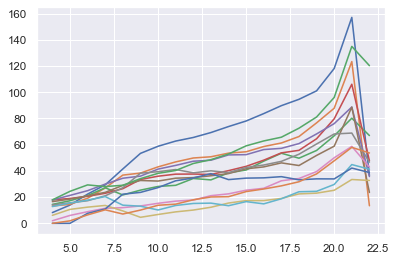

In [44]:
fig,ax = plt.subplots()
for t in error_sv.time:
    ax.plot(error_sv.sel(time=t).isoline[::-1], error_sv.sel(time=t).values)

# Iso-line selection
Plot vertical gradient (low-pass filtered in vertical direction)

In [95]:
# arguments for experimental setup
name  = 'rho'
delta = 25 if name=='T' else 2
iso_vals = np.arange(4,23) if name=='T' else np.arange(26,27.75,.1)
arg_list = zip_args(name, iso_vals, delta)

with Pool(16) as p:
    zgrads_allyears = p.map(get_mean_zgrad_multi, arg_list)
zgrads_allyears = xr.concat(zgrads_allyears, dim=data.time)

Plot result

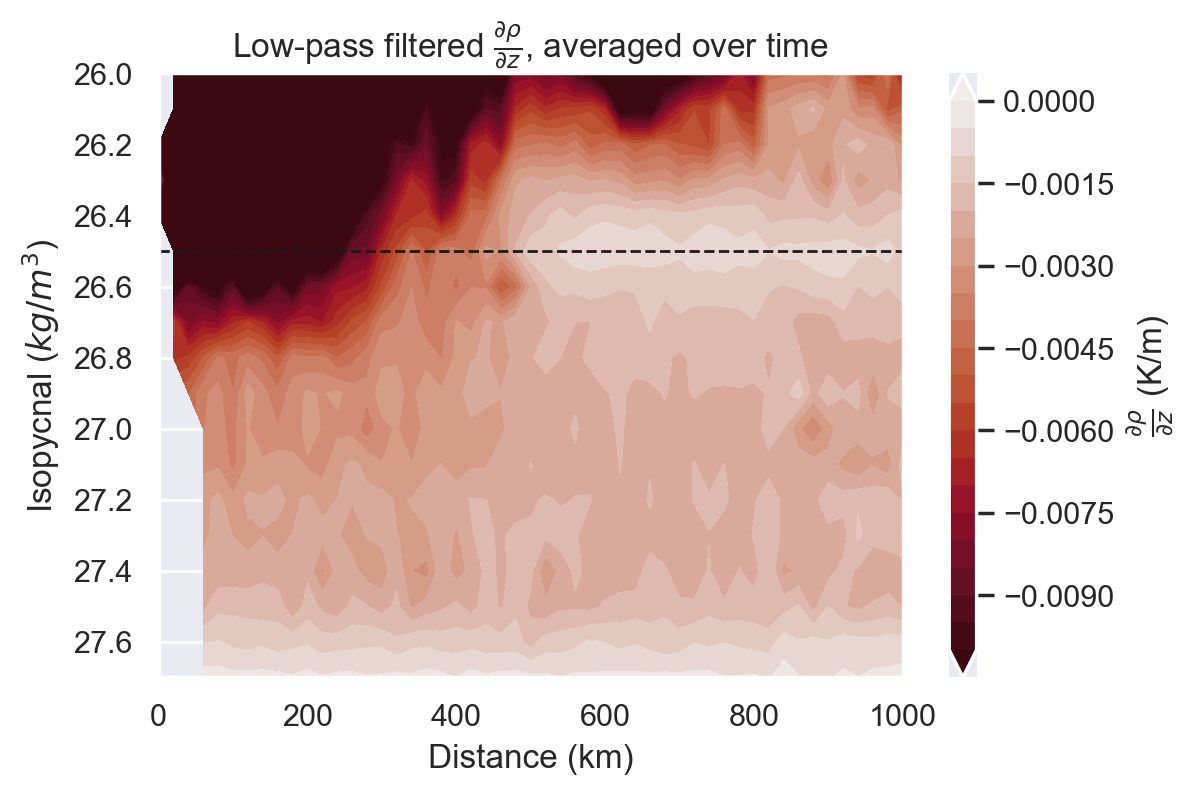

In [96]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']=200
### Plotting
fig,ax = plt.subplots()

if name=='T':
    cp = ax.contourf(zgrads_allyears.dist, zgrads_allyears.isoline, zgrads_allyears.mean('time'), 
                     cmap='cmo.amp', levels=np.arange(0,.05,.005), extend='max')
    cb = fig.colorbar(cp, label=r'$\frac{\partial \theta}{\partial z}$ (K/m)')
    ax.set_ylabel('Isotherm (K)')
    ax.set_title(r'Low-pass filtered $\frac{\partial\theta}{\partial z}$, averaged over time')
    ax.axhline(12, ls='--',c='k',lw=1)
else:
    cp = ax.contourf(zgrads_allyears.dist, zgrads_allyears.isoline, zgrads_allyears.mean('time'), 
                     cmap='cmo.amp_r', levels=np.arange(-.01,0.0005,.0005), extend='both')
    cb = fig.colorbar(cp, label=r'$\frac{\partial \rho}{\partial z}$ (K/m)')
    ax.set_ylabel(r'Isopycnal ($kg/m^3$)')
    ax.set_title(r'Low-pass filtered $\frac{\partial\rho}{\partial z}$, averaged over time')
    ax.axhline(26.5, ls='--',c='k',lw=1)
    plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down

ax.set_xlabel('Distance (km)')

plt.show()

# Old code

Compute vertical gradient for single sample

In [32]:
time_idx = 3
name     = 'T'
delta    =25
data_ = data.isel(time=time_idx)[name]

iso_vals = np.arange(4,23)
zgrads = get_mean_zgrad_multi(data_, iso_vals, delta)

## First try: plot vertical gradient everywhere

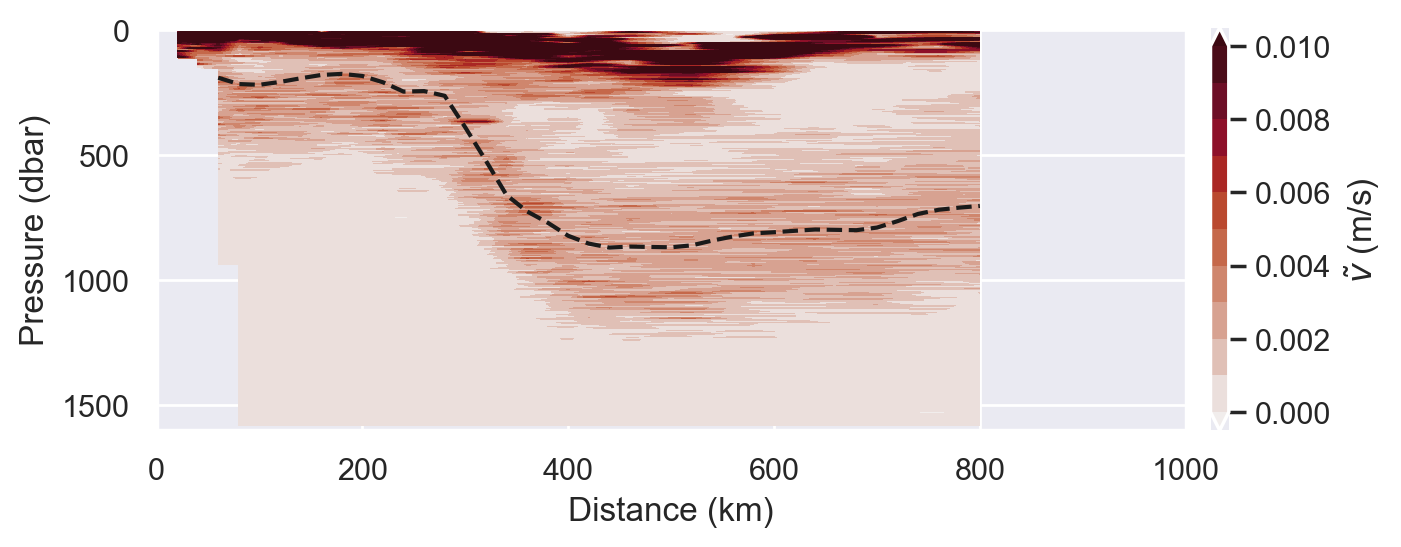

In [82]:
time_idx=1
name = 'rho'
zgrad = data.differentiate('depth')[name]

##### Plotting 
c = sns.color_palette()
figsize = np.array([8,16/6])
fig = plt.figure(figsize=figsize)
gs = fig.add_gridspec(10,30)
#### Plot Velocity profile ####
ax = fig.add_subplot(gs[:,:])
if name=='T':
    p = ax.contourf(zgrad.dist, zgrad.depth, -zgrad.isel(time=time_idx).T, cmap='cmo.amp', extend='both',
                    levels=np.arange(0,.11,.01))
else:
    p = ax.contourf(zgrad.dist, zgrad.depth, zgrad.isel(time=time_idx).T, cmap='cmo.amp', extend='both',
                    levels=np.arange(0,.011,.001))
cb = fig.colorbar(p, orientation='vertical', label=r'$\tilde{v}$ (m/s)', pad=.02)

# Iso-lines (temperature or density)
data_plot = data.isel(time=time_idx)[name_plot].T
levels    = np.arange(0,25,2) if name_plot=='T' else 12

ax.plot(iso.dist, iso.values, c='k', ls='--')
ax.error
ax.set_ylabel('Pressure (dbar)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1600])
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down

plt.show()